In [ ]:
#!pip uninstall lmoments3

In [ ]:
#!pip install git+https://github.com/OpenHydrology/lmoments3.git

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.legend_handler import HandlerLine2D
import scipy.misc


%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,6

**Extreme Value Analysis of pressure data based on Tutorial by Chonghua Yin**

https://www.linkedin.com/pulse/beginners-guide-carry-out-extreme-value-analysis-2-chonghua-yin

First let us load our atmospheric pressure data

In [ ]:
data=pd.read_csv('target_data.csv')
print(data.tail())

       Unnamed: 0    Year  Data target
10588  27/12/2070  2070.0            0
10589  28/12/2070  2070.0            0
10590  29/12/2070  2070.0            0
10591  30/12/2070  2070.0            0
10592  31/12/2070  2070.0            0


We also need to install the Python package L-moments used to calibrate the parameters of the distributions to be use
https://pypi.org/project/lmoments/[link text](https:// [link text](https://))
L-moments supports the following distributions: 
*Exponential (EXP)
*Gamma (GAM)
*Generalised Extreme Value (GEV)
*Generalised Logistic (GLO)
*Generalised Normal (GNO)
*Generalised Pareto (GPA)
*Gumbel (GUM)
*Kappa (KAP)
*Normal (NOR)
*Pearson III (PE3)
*Wakeby (WAK)
*Weibull (WEI)

In [ ]:
import lmoments3 as lm
from lmoments3 import distr


We need then to select extreme values from the dataset

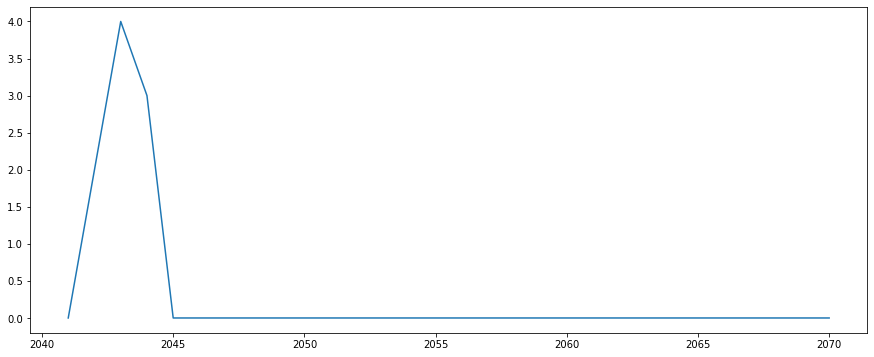

In [ ]:
df=data.groupby('Year')['Data target'].max()
plt.plot(df)

# Fitting GEV distribution to the data

Let us calculate the L-moments before fitting the data

In [ ]:
LMU = lm.lmom_ratios(df, nmom=5)
LMU

[6.902616666666666e-05,
 2.1110257575757577e-05,
 -0.27723345752495737,
 0.09653045781037563,
 0.04215026875488504]

Let us then fit GEV distribution and estimate the parameters

In [ ]:
gevfit = distr.gev.lmom_fit(LMU)
expfit = distr.exp.lmom_fit(LMU)
gumfit = distr.gum.lmom_fit(LMU)
#weifit = distr.wei.lmom_fit(LMU)
#gpafit = distr.gpa.lmom_fit(LMU)
#pe3fit = distr.pe3.lmom_fit(LMU)
#gamfit = distr.gam.lmom_fit(LMU)
#glofit = distr.glo.lmom_fit(LMU)

Getting Extreme Pressure According to a specific return year 
**Let us use three distributions only for the sake of the example**

In [ ]:
gevfitted=distr.gev(**gevfit)
expfitted=distr.exp(**expfit)
gumfitted=distr.gum(**gumfit)

In [ ]:
# return years (1.1 to 1000)
T = np.arange(0.1, 999.1, 0.1) + 1

# extreme pressure
gevfitted=distr.gev(**gevfit)
gevST=gevfitted.ppf(1.0-1./T)

expfitted=distr.exp(**expfit)
expST=expfitted.ppf(1.0-1./T)

gumfitted=distr.gum(**gumfit)
gumST=gumfitted.ppf(1.0-1./T)

gevST
expST
gumST

array([-0.19308735, -0.15989082, -0.13705709, ...,  0.69342443,
        0.69343583,  0.69344723])

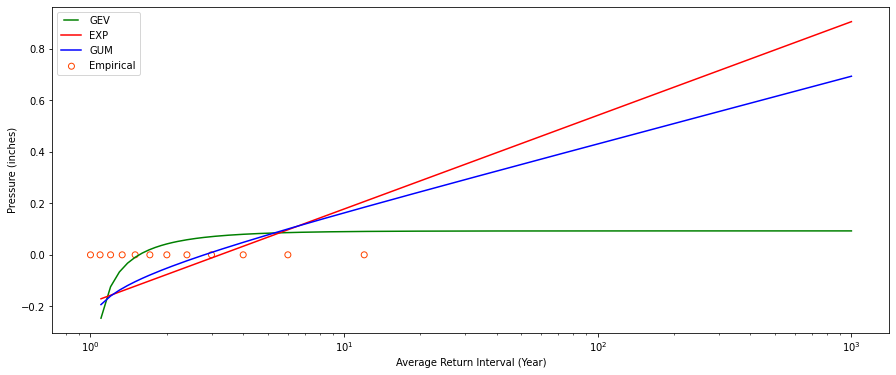

In [ ]:
# setup plotting parameters
plt.xscale('log')
plt.xlabel('Average Return Interval (Year)')
plt.ylabel('Pressure (inches)')

# draw extreme values from GEV distribution
line1, = plt.plot(T, gevST, 'g', label='GEV')
line2, = plt.plot(T, expST, 'r', label='EXP')
line3, = plt.plot(T, gumST, 'b', label='GUM')
#line4, = plt.plot(T, weiST, 'y', label='WEI')
#line5, = plt.plot(T, gpaST, 'c', label='GPA')
#line6, = plt.plot(T, pe3ST, 'm', label='PE3')
#line7, = plt.plot(T, gamST, 'k', label='GAM')
#line8, = plt.plot(T, gloST, c='orange', label='GLO')

# draw extreme values from observations(empirical distribution)
N    = np.r_[1:len(df.index)+1]*1.0 #must *1.0 to convert int to float
Nmax = max(N)

plt.scatter(Nmax/N, sorted(df)[::-1], color = 'orangered', facecolors='none', label='Empirical')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})

# Finding an optimal distribution

Use of the kolmogorov-Smirnov test
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html 

In [ ]:
from scipy import stats as stats

# prepare probabilites according to observations
N    = np.r_[1:len(df.index)+1]*1.0 #must *1.0 to convert int to float
Nmax = max(N)   
P0   = (N-1.)/Nmax
P    = np.delete(P0,0)

obs = sorted(df)[1:]

# extreme precipitations
gevSTo = gevfitted.ppf(1.0-1./P)
expSTo = expfitted.ppf(1.0-1./P) 
gumSTo = gumfitted.ppf(1.0-1./P)


# do ks test
ks = [('GEV', stats.ks_2samp(obs, gevSTo)), ('EXP', stats.ks_2samp(obs, expSTo)),
      ('GUM', stats.ks_2samp(obs, gumSTo))]

labels = ['Distribution', 'KS (statistics, pvalue)']
pd.DataFrame(ks, columns=labels)

,Distribution,"KS (statistics, pvalue)"
0,GEV,"(1.0, 2.835142154027603e-06)"
1,EXP,"(1.0, 2.835142154027603e-06)"
2,GUM,"(1.0, 2.835142154027603e-06)"


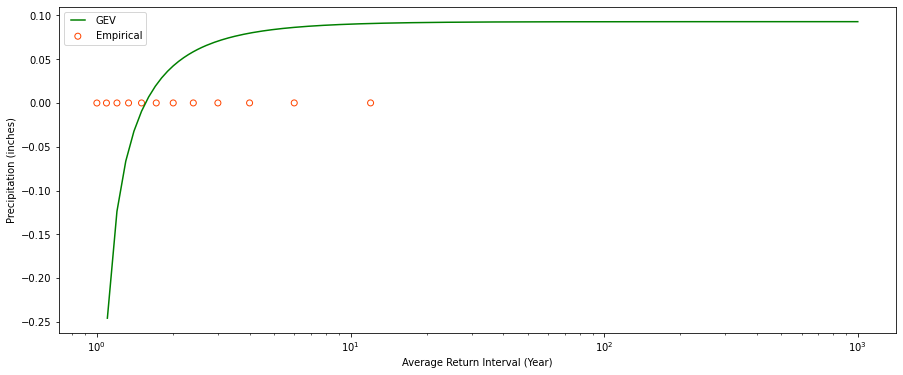

In [ ]:
plt.xscale('log')
plt.xlabel('Average Return Interval (Year)')
plt.ylabel('Precipitation (inches)')
line1, = plt.plot(T, gevST, 'g', label='GEV')

# draw extreme values from observations(empirical distribution)
N    = np.r_[1:len(df.index)+1]*1.0 #must *1.0 to convert int to float
Nmax = max(N)

plt.scatter(Nmax/N, sorted(df)[::-1], color = 'orangered', facecolors='none', label='Empirical')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})